<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/k2_pix_small.png">
*This notebook contains an excerpt instructional material from [gully](https://twitter.com/gully_) and the [K2 Guest Observer Office](https://keplerscience.arc.nasa.gov/); the content is available [on GitHub](https://github.com/gully/goldenrod).*


<!--NAVIGATION-->
< [goldenrod](02.03-SN_model-fits-Kepler_SN.ipynb) | [Contents](Index.ipynb) | [! wget -r https://archive.stsci.edu/pub/kepler/target_pixel_files/0031/003111451/](02.05-TPFs_of_supernovas_2011b.ipynb) >

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import sncosmo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
KEGS_header = pd.read_csv('../data/KSN-2011b_raw_data.dat', skiprows=11, sep=r'\s{2,}', nrows=0, engine='python')
names = KEGS_header.columns.str.strip('#').str.replace(' ', '').str.replace('-', '_')
ksn2011b = pd.read_csv('../data/KSN-2011b_raw_data.dat', comment='#', names=names, delim_whitespace=True)
ksn2011b.head()

,KJD,KJD_T_EXP,KJD_T_MAX,LC_val_BCK,LC_err
0,964.77569,-29.98871,-49.04431,0.01157,0.01011
1,964.79613,-29.96827,-49.02387,0.00186,0.01027
2,964.81656,-29.94784,-49.00344,-0.00355,0.01065
3,964.83699,-29.92741,-48.98301,-0.00459,0.00976
4,964.85743,-29.90697,-48.96257,0.00710,0.01097


In [4]:
gen_model = sncosmo.Model(source='hsiao')
gen_model.set(z=0, t0=1015., amplitude=5.5e-7)
model1 = gen_model.bandflux('kepler', ksn2011b.KJD)

In [5]:
from celerite.modeling import Model

# Define the model
class MeanModel(Model):
    parameter_names = ("z", "t0", "amp")

    def get_value(self, t):
        gen_model.set(z=self.z, t0=self.t0, amplitude=self.amp)
        model_out = gen_model.bandflux('kepler', t)
        return model_out

In [6]:
bounds_dict = {'z':(0.0001,0.2), 't0':(900,1100), 'amp':(1.0e-9, 1.0e-3)}
mean_model = MeanModel(z=0.01, t0=1015.0, amp=5.5e-7, bounds=bounds_dict)
true_params = mean_model.get_parameter_vector()

# Simuate the data
np.random.seed(42)

In [7]:
x = ksn2011b.KJD.values
yerr = x*0.0+0.01
y = ksn2011b.LC_val_BCK.values

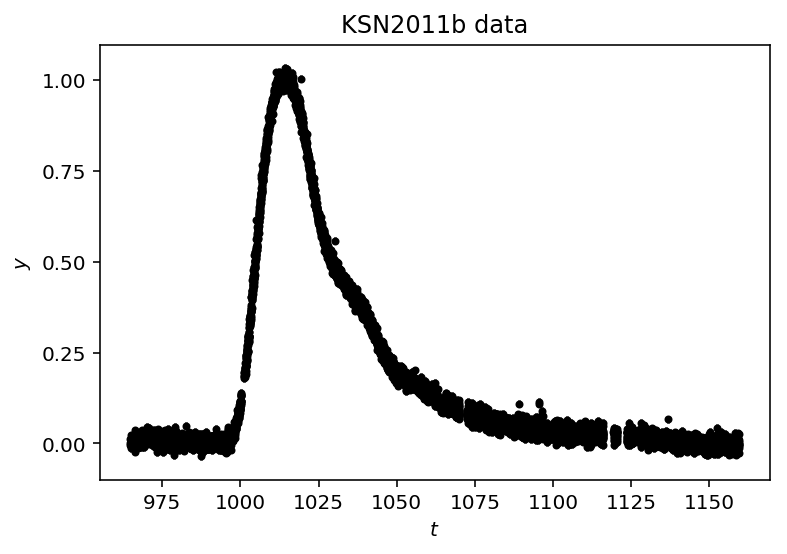

In [8]:
# Plot the data
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
#plt.xlim(-5, 5)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("KSN2011b data");

In [9]:
np.var(y)

0.077205271537220538

In [ ]:
kernel2 = terms.

In [10]:
from scipy.optimize import minimize

import celerite
from celerite import terms

# Set up the GP model
kernel = terms.RealTerm(log_a=np.log(np.var(y)), log_c=-np.log(10.0))
gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
gp.compute(x, yerr)

In [11]:
print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))

Initial log-likelihood: 23290.849608704353


In [12]:
# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()

In [13]:
initial_params

array([ -2.56128754e+00,  -2.30258509e+00,   1.00000000e-02,
         1.01500000e+03,   5.50000000e-07])

In [14]:
%%time
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

Final log-likelihood: 26206.148732680675
CPU times: user 1min 17s, sys: 19.5 s, total: 1min 37s
Wall time: 1min 37s


In [15]:
# Make the maximum likelihood prediction
t = x
mu, var = gp.predict(y, t, return_var=True)
std = np.sqrt(var)

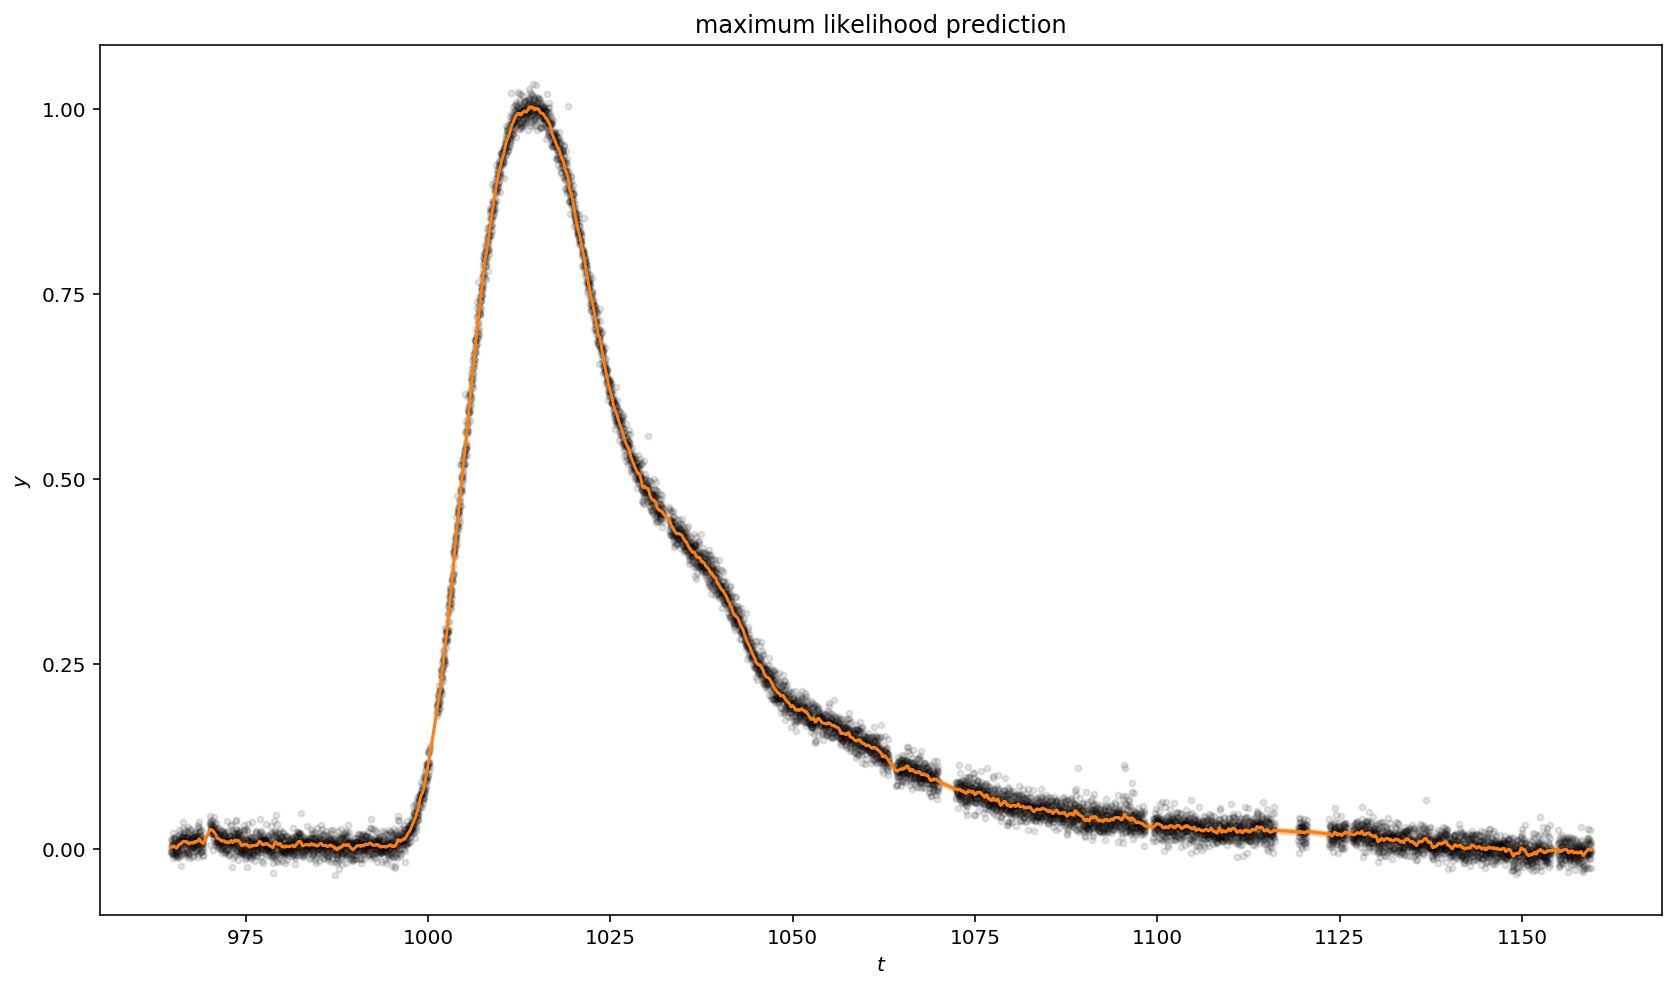

In [16]:
plt.figure(figsize=(14, 8))
# Plot the data
color = "#ff7f0e"
plt.plot(x, y, ".k", alpha=0.1)
plt.plot(t, mu, color=color)
plt.fill_between(t, mu+std, mu-std, color=color, alpha=0.3, edgecolor="none")
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
#plt.xlim(-5, 5)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("maximum likelihood prediction");

In [17]:
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(y) + lp

In [18]:
gp.parameter_names

('kernel:log_a', 'kernel:log_c', 'mean:z', 'mean:t0', 'mean:amp')

In [19]:
gp.parameter_vector

array([ -5.28203710e+00,  -4.98929075e+00,   1.51721614e-02,
         1.01337261e+03,   5.46871306e-07])

In [20]:
import emcee

initial = np.array(soln.x)
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=8)

In [21]:
%%time
print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

Running burn-in...
CPU times: user 3.46 s, sys: 554 ms, total: 4.01 s
Wall time: 22min 37s


In [22]:
%%time
print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);

Running production...
CPU times: user 13.2 s, sys: 2.11 s, total: 15.3 s
Wall time: 1h 27min 21s


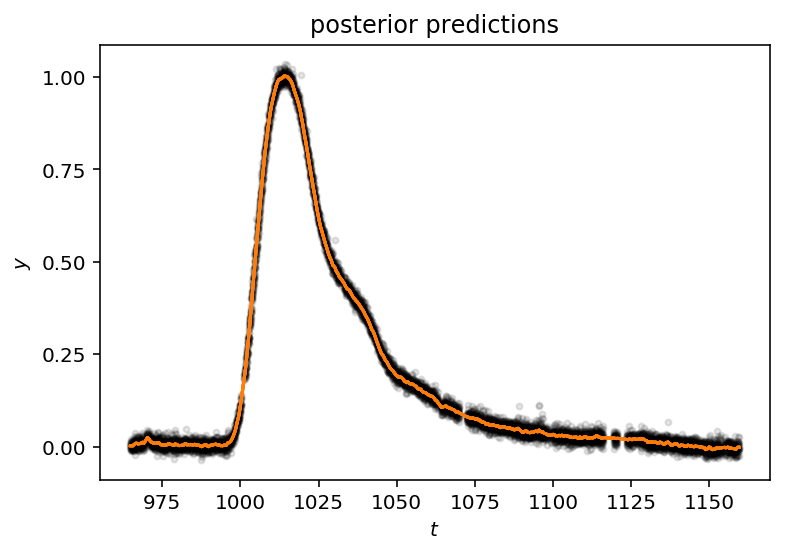

In [24]:
# Plot the data.
plt.plot(x, y,".k", alpha=0.1)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(y, t, return_cov=False)
    plt.plot(t, mu, color="#0e7fff", alpha=0.3)

plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
#plt.xlim(-5, 5)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("posterior predictions");

In [39]:
labels = [*mean_model.parameter_names]+[r"$\alpha$", r"$\ell$"]

In [40]:
labels

['z', 't0', 'amp', '$\\alpha$', '$\\ell$']

In [44]:
true_params = np.hstack([true_params, [np.var(y)], [10.0]])

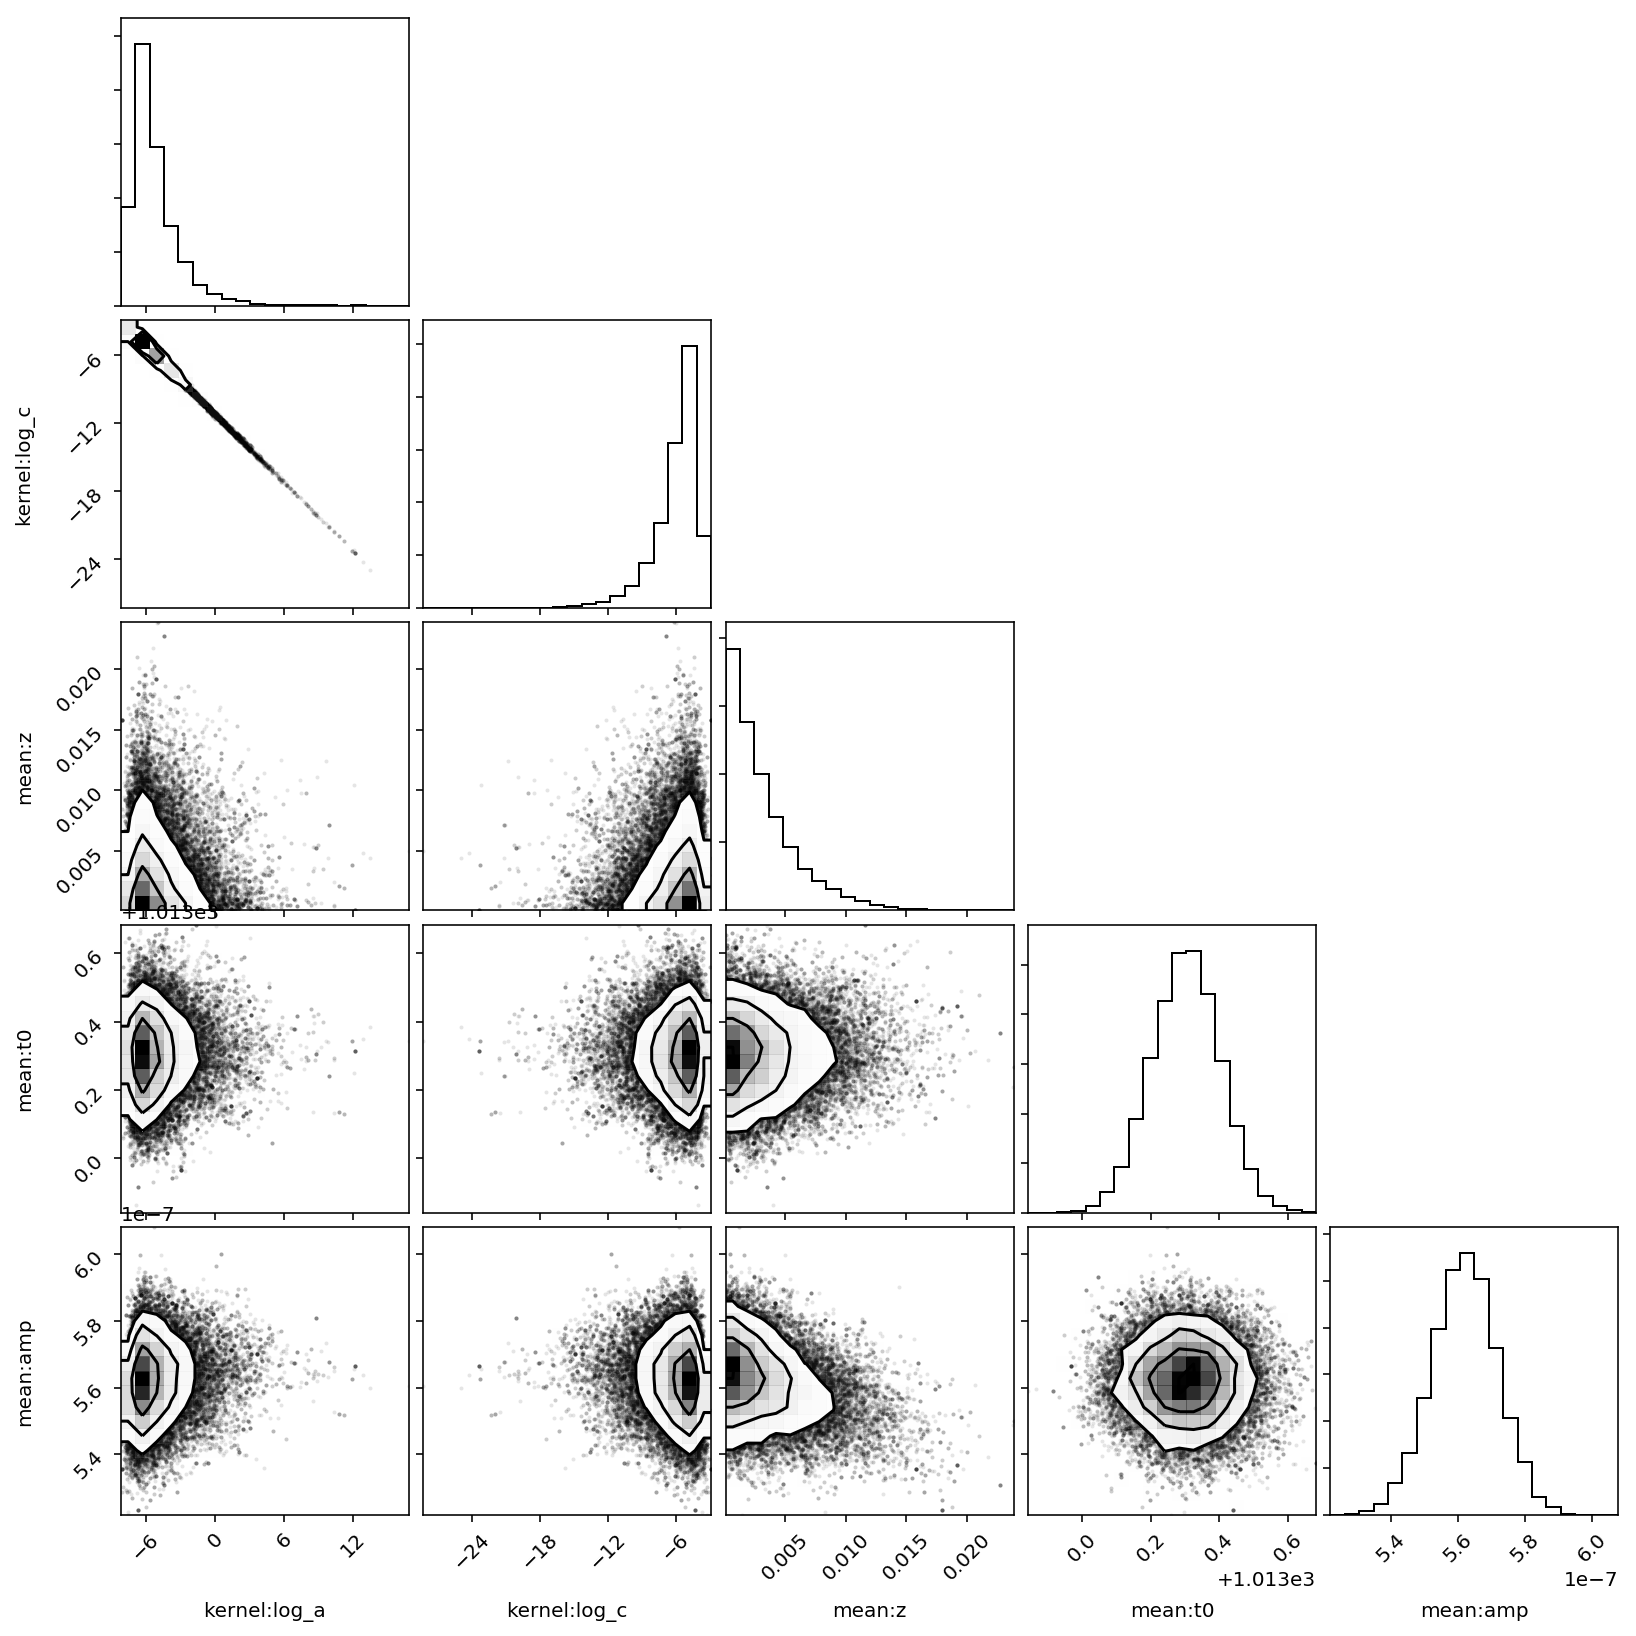

In [47]:
import corner
cols = mean_model.get_parameter_names()
corner.corner(sampler.flatchain,
              labels=names);

In [54]:
s[2:]

array([  1.06998661e-03,   1.01333823e+03,   5.77809597e-07])

In [53]:
gp.parameter_names

('kernel:log_a', 'kernel:log_c', 'mean:z', 'mean:t0', 'mean:amp')

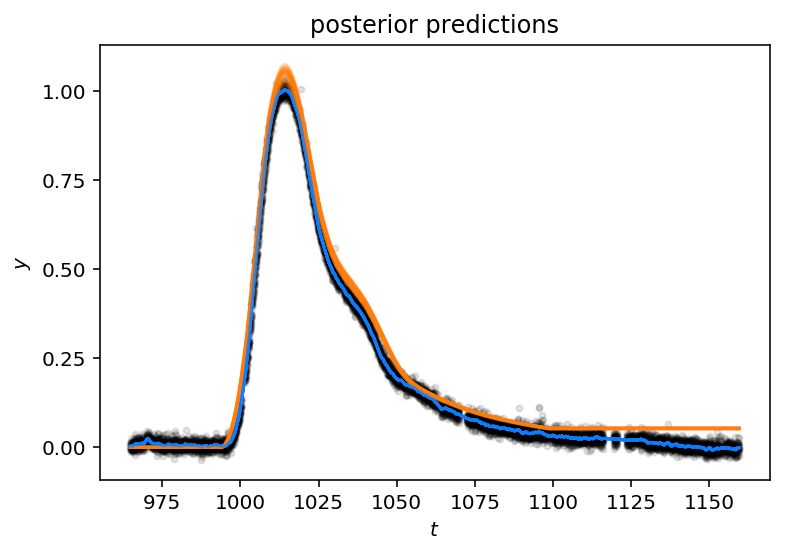

In [57]:
# Plot the data.
plt.plot(x, y,".k", alpha=0.1)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    z, t0, amp = s[2:]
    gen_model.set(z=z, t0=t0, amplitude=amp)
    model1 = gen_model.bandflux('kepler', ksn2011b.KJD)
    plt.plot(t, model1, color=color, alpha=0.3)
    gp.set_parameter_vector(s)
    mu = gp.predict(y, t, return_cov=False)
    plt.plot(t, mu, color="#0e7fff", alpha=0.3)

plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
#plt.xlim(-5, 5)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("posterior predictions");

In [48]:
sampler.flatchain.shape

(64000, 5)

In [50]:
val, =  np.random.randint(0, 64000, 1)

In [51]:
val

40447

In [76]:
mu, cov = gp.predict(y, t, return_cov=True)

In [59]:
mu.shape, cov.shape

((8742,), (8742, 8742))

In [61]:
cov.min()

-1.3600232051658168e-15

In [62]:
import seaborn as sns

In [64]:
cov.flatten().shape

(76422564,)

In [66]:
cov.shape

(8742, 8742)

In [71]:
cov2 = cov.copy()
cov2[np.diag_indices(8742)]  = 0

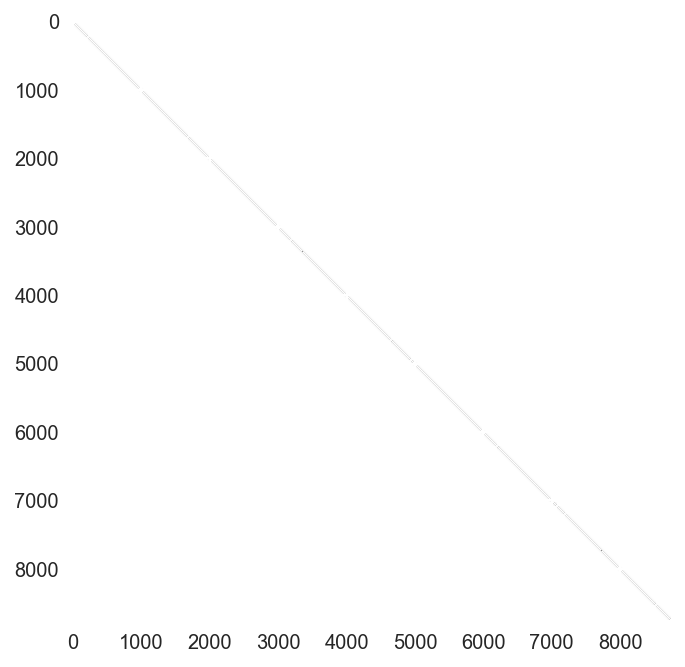

In [73]:
plt.imshow(cov2)

RESIDUALS

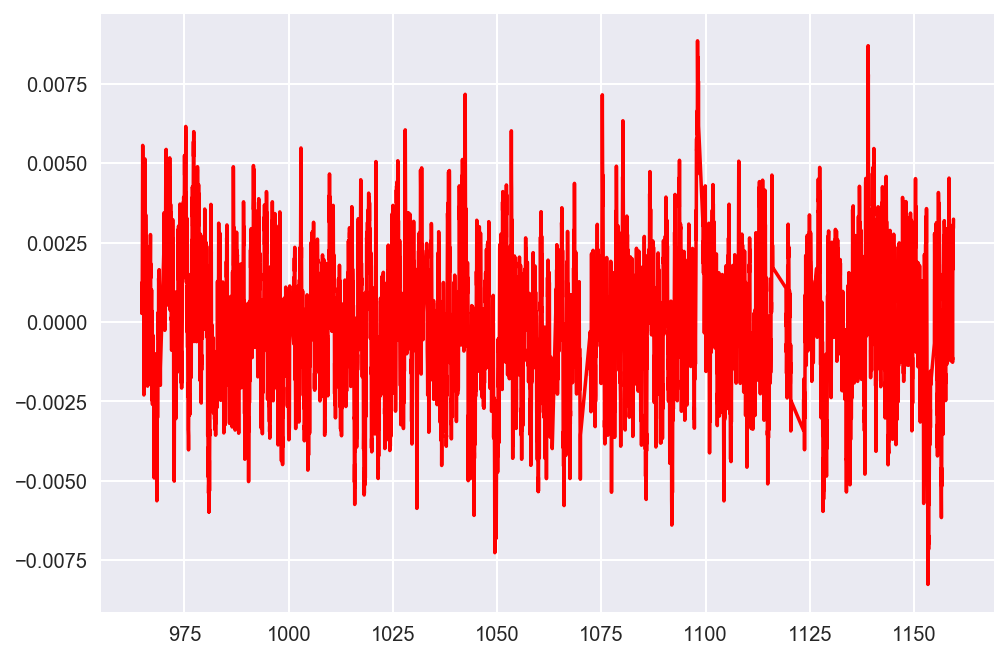

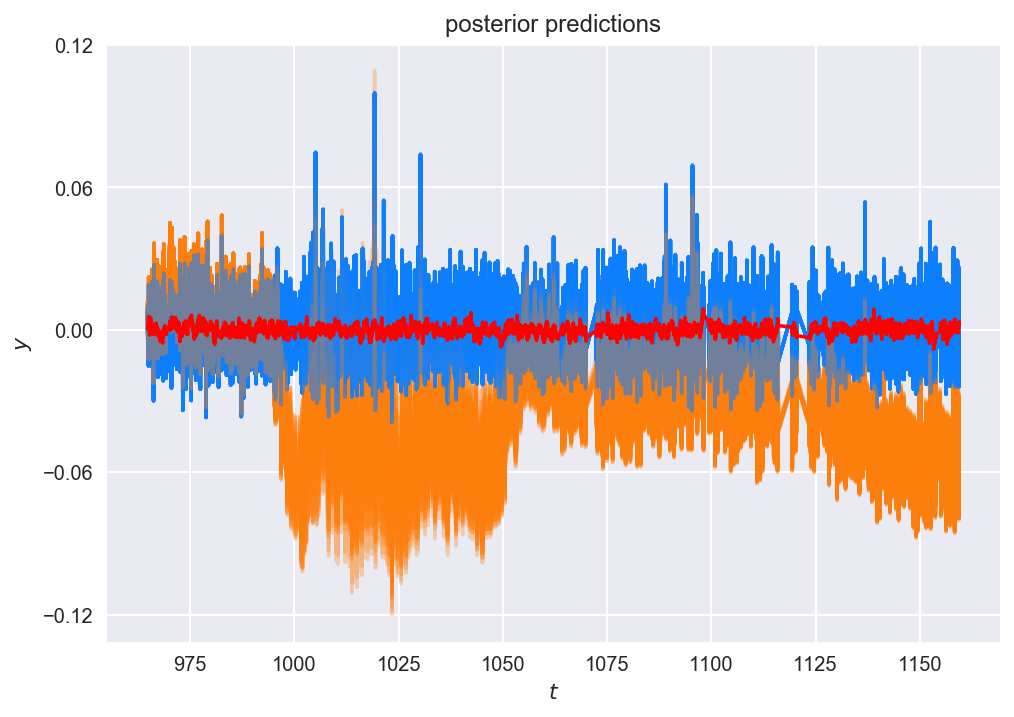

In [83]:
# Plot the data.

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    z, t0, amp = s[2:]
    gen_model.set(z=z, t0=t0, amplitude=amp)
    model1 = gen_model.bandflux('kepler', ksn2011b.KJD)
    plt.plot(t, y - model1, color=color, alpha=0.3)
    gp.set_parameter_vector(s)
    mu = gp.predict(y, t, return_cov=False)
    plt.plot(t, y-mu, color="#0e7fff", alpha=0.3)

plt.plot(x, draw,"r-", alpha=1)
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
#plt.xlim(-5, 5)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("posterior predictions");

In [79]:
draw

array([ 0.00027766,  0.00030732,  0.0010089 , ...,  0.00294504,
        0.00300328,  0.00323781])

In [77]:
draw = np.random.multivariate_normal(mu*0.0, cov)

The end.

<!--NAVIGATION-->
< [goldenrod](02.03-SN_model-fits-Kepler_SN.ipynb) | [Contents](Index.ipynb) | [! wget -r https://archive.stsci.edu/pub/kepler/target_pixel_files/0031/003111451/](02.05-TPFs_of_supernovas_2011b.ipynb) >